Step 1: Downloading NLTK real movie reviews...
[OK] Data loaded. Total samples: 2000
Step 2: Preprocessing text (cleaning noise)...
Step 3: Training model (LinearSVC with TF-IDF)...

Accuracy Score: 84.25%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.81      0.84       199
    Positive       0.83      0.87      0.85       201

    accuracy                           0.84       400
   macro avg       0.84      0.84      0.84       400
weighted avg       0.84      0.84      0.84       400


Step 4: Generating visualization...


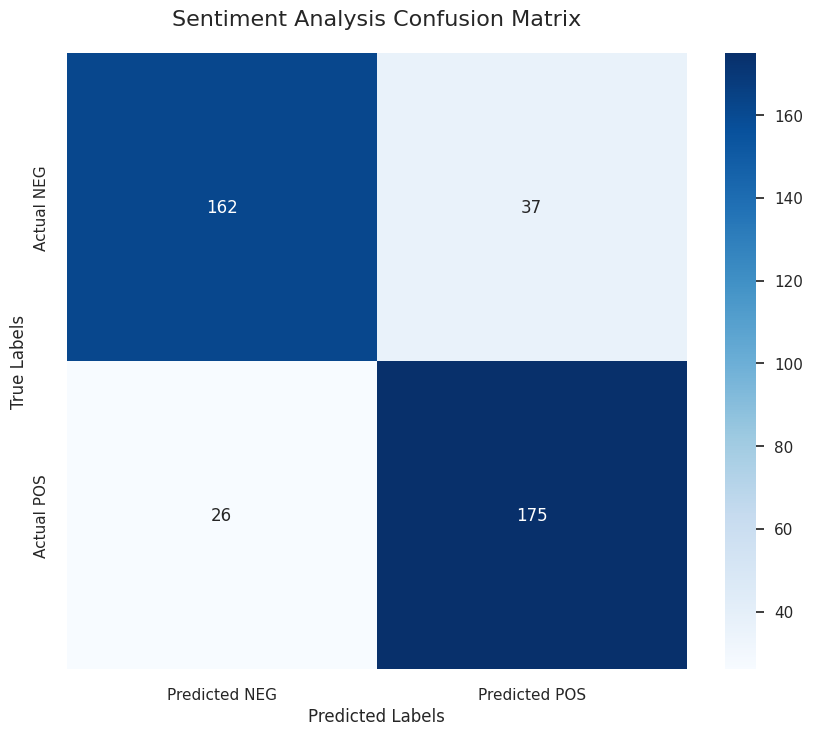


[SUCCESS] Plot saved as 'sentiment_analysis_result.png'


In [ ]:
#  情感分析实战：使用 NLTK 影评数据集训练 LinearSVC 模型，并生成可视化结果
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import nltk # NLTK (Natural Language Toolkit)

# --- 1. 强力静音模式：彻底关闭 Matplotlib 字体报警和所有警告 ---
logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

# --- 2. 准备数据集 ---
print("Step 1: Downloading NLTK real movie reviews...")
nltk.download('movie_reviews', quiet=True)
nltk.download('stopwords', quiet=True)
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords

def load_nltk_data():
    documents = []
    # 提取 NLTK 自带的 2000 条正负面影评
    for category in movie_reviews.categories():
        for fileid in movie_reviews.fileids(category):
            documents.append({
                'review': movie_reviews.raw(fileid),
                'sentiment': 1 if category == 'pos' else 0
            })
    df = pd.DataFrame(documents)
    print(f"[OK] Data loaded. Total samples: {len(df)}")
    return df

# --- 3. 文本预处理 ---
stop_words = set(stopwords.words('english')) # 英文停用词列表 废话 如 i, me, my, ourselves, you, are, is, a, the...
# 可以添加自定义停用词 代码如下
custom_stop_words = {'movie', 'film', 'one', 'like', 'good', 'even', 'time', 'see', 'really', 'much'}
stop_words = stop_words.union(custom_stop_words) # union 合并两个集合 列表合并+保留重复项

def preprocess_text(text):
    # 转小写并移除特殊字符
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    # 移除停用词 (the, is, a 等) 只保留 a-z 和空格，去掉标点和数字
    # re.sub(pattern, replacement, string): 在 string 中找到符合 pattern 的部分，替换成 replacement
    # 找到所有不是小写字母、也不是空格的字符，把它们变成‘空’
    words = text.split() # 分词：按空格切开 列表
    return " ".join([w for w in words if w not in stop_words]) # 字符串
# 处理前： "the movie was not that great and i hated the acting!"
# 处理后： "movie great hated acting"
# TF (Term Frequency) 词频： 一个词在这一篇文章中出现次数越多，越重要。
# IDF (Inverse Document Frequency) 逆文档频率：
# 如果一个词在所有文章中都频繁出现（比如“movie”），那它就不具备区分度，得分要调低。

# --- 4. 核心训练与可视化逻辑 ---
def main(): # 在函数内部定义的变量是局部变量 运行结束后 函数内部的所有变量（df, pipeline, X_train 等）都会被系统从内存中销毁
    df = load_nltk_data()
    
    print("Step 2: Preprocessing text (cleaning noise)...")
    df['clean_review'] = df['review'].apply(preprocess_text) # 新增一列 'clean_review'，存放预处理后的文本
    
    # 划分 80% 训练，20% 测试
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.svm import LinearSVC
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

    X_train, X_test, y_train, y_test = train_test_split(
        df['clean_review'], df['sentiment'], test_size=0.2, random_state=42
    )

    # 构建 Pipeline：TF-IDF 特征工程 + LinearSVC 分类器
    print("Step 3: Training model (LinearSVC with TF-IDF)...")
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))), # 考虑单个词和双词组合（如 "not good"）最多记住 10000 个特征
        ('clf', LinearSVC()) # Support Vector Classification
    ]) # 无论你的评论是只有 3 个词还是有 300 个词，它转换后的向量长度固定为 10000
    # 如果这篇评论里没出现某个词，对应的位置就是 0
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

# X_train 经过 TfidfVectorizer 后的样子：形状 (1600, 10000) 的稀疏矩阵 (样本数, 词汇量)
# 一个影评只有几十个词，但词库有一万个词。稀疏矩阵只记录“哪个位置有值”

    # --- 5. 打印结果 (控制台支持中文，没问题) ---
    print("\n" + "="*40)
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])) #给 0 和 1 起个名字
    print("="*40)

    # --- 6. 绘图 (全英文标签，完美避开 Colab 字体坑) ---
    print("\nStep 4: Generating visualization...")
    plt.figure(figsize=(10, 8))
    
    # 设置绘图风格
    sns.set_theme(style="white")
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted NEG', 'Predicted POS'], 
                yticklabels=['Actual NEG', 'Actual POS'])
    
    plt.title('Sentiment Analysis Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    
    # 保存并显示
    plt.savefig('sentiment_analysis_result.png', dpi=300)
    plt.show()
    print("\n[SUCCESS] Plot saved as 'sentiment_analysis_result.png'")

if __name__ == "__main__":
    main()

In [10]:
df = load_nltk_data()
df.head()

[OK] Data loaded. Total samples: 2000


,review,sentiment
0,"plot : two teen couples go to a church party ,...",0
1,the happy bastard's quick movie review \ndamn ...,0
2,it is movies like these that make a jaded movi...,0
3,""" quest for camelot "" is warner bros . ' firs...",0
4,synopsis : a mentally unstable man undergoing ...,0


Google Colab 的内核运行在 Google 的 Linux 虚拟机上，这些机器为了精简，默认只安装了基本的英文和符号字体，根本没有 SimHei（黑体）或其他中文字体

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. 准备一小段模拟数据
X_sample = [
    "I love this movie",
    "I hate this movie"
]

# 2. 初始化并转换
# 为了方便观察，我们不限制特征数，并关掉停用词
# 如果你不限制特征数，特征数就等于：整个训练集中所有不重复单词（Unique Words）的总数。
# 电影评论数据集：总共有 2000 条评论。如果不限制，
# 经过清洗后的不重复单词通常在 30,000 到 50,000 个左右。
# 占内存多，且维度灾难：特征太多（如 5 万个），而样本太少（只有 1600 个训练样本）过拟合

# 除了此处 max_features=10000，TfidfVectorizer ：
# min_df=5 表示“如果一个词在所有文档中出现次数少于 5 次，就把它扔掉”。过滤掉拼写错误和极其罕见的词。

# max_df=0.8 表示“如果一个词在 80% 的文档里都出现过，就把它扔掉”。
# 这能过滤掉那些虽然不是停用词，但在当前语境下（如电影评论里的“movie”）出现过于频繁而失去分类意义的词。
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_sample)

# --- 查看形状 (Shape) ---
print(f"向量的形状: {X_tfidf.shape}") 
# 输出会是 (2, 4)，表示 2 行（两个句子），4 列（总共 4 个不重复的词）

# --- 查看词汇表 (Vocabulary) ---
print(f"词汇表对应的位置: {tfidf.vocabulary_}")
# 输出类似于: {'love': 2, 'this': 3, 'movie': 1, 'hate': 0}

# --- 查看具体数字 (变成普通数组看) ---
print("\n转换后的数字矩阵:")
print(X_tfidf.toarray())

向量的形状: (2, 4)
词汇表对应的位置: {'love': 1, 'this': 3, 'movie': 2, 'hate': 0}

转换后的数字矩阵:
[[0.         0.70490949 0.50154891 0.50154891]
 [0.70490949 0.         0.50154891 0.50154891]]


Step 1: Downloading NLTK real movie reviews...
[OK] Data loaded. Total samples: 2000
Step 2: Preprocessing text (cleaning noise)...
Step 3: Training model (LinearSVC with TF-IDF)...

Accuracy Score: 84.75%

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.82      0.84       199
    Positive       0.83      0.88      0.85       201

    accuracy                           0.85       400
   macro avg       0.85      0.85      0.85       400
weighted avg       0.85      0.85      0.85       400


Step 4: Generating visualization...


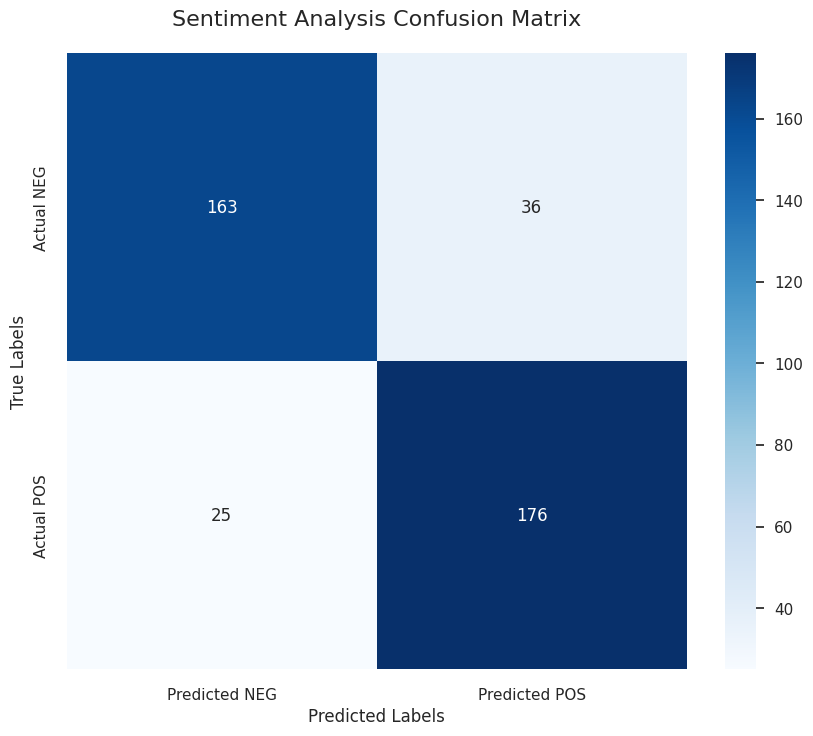


[SUCCESS] Model is ready. You can now use 'pipeline' in the next cell.


In [14]:
# --- 1. 导入库与环境设置 ---
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import nltk
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords

# 强力静音模式：彻底关闭报警
logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

# --- 2. 准备数据集 ---
print("Step 1: Downloading NLTK real movie reviews...")
nltk.download('movie_reviews', quiet=True)
nltk.download('stopwords', quiet=True)

def load_nltk_data():
    documents = []
    for category in movie_reviews.categories():
        for fileid in movie_reviews.fileids(category):
            documents.append({
                'review': movie_reviews.raw(fileid),
                'sentiment': 1 if category == 'pos' else 0
            })
    df = pd.DataFrame(documents)
    print(f"[OK] Data loaded. Total samples: {len(df)}")
    return df

df = load_nltk_data()

# --- 3. 文本预处理设置 ---
# 准备停用词
stop_words = set(stopwords.words('english'))
custom_stop_words = {'movie', 'film', 'one', 'even', 'time', 'see', 'really', 'much'}
stop_words = stop_words.union(custom_stop_words)

def preprocess_text(text):
    # 转小写并移除特殊字符（只保留 a-z 和空格）
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    # 分词并过滤停用词
    words = text.split()
    return " ".join([w for w in words if w not in stop_words])

print("Step 2: Preprocessing text (cleaning noise)...")
df['clean_review'] = df['review'].apply(preprocess_text)

# --- 4. 划分数据集与训练 ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 划分 80% 训练，20% 测试
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['sentiment'], test_size=0.2, random_state=42
)

# 构建 Pipeline：TF-IDF 特征工程 + LinearSVC 分类器
print("Step 3: Training model (LinearSVC with TF-IDF)...")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=10000, ngram_range=(1, 2))),
    ('clf', LinearSVC())
])

# 开始训练
pipeline.fit(X_train, y_train)

# 进行预测
y_pred = pipeline.predict(X_test)

# --- 5. 打印评估结果 ---
print("\n" + "="*40)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
print("="*40)

# --- 6. 绘图可视化 ---
print("\nStep 4: Generating visualization...")
plt.figure(figsize=(10, 8))
sns.set_theme(style="white")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted NEG', 'Predicted POS'], 
            yticklabels=['Actual NEG', 'Actual POS'])

plt.title('Sentiment Analysis Confusion Matrix', fontsize=16, pad=20)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

plt.savefig('sentiment_analysis_result.png', dpi=300)
plt.show()
print("\n[SUCCESS] Model is ready. You can now use 'pipeline' in the next cell.")

In [ ]:
# 测试你的模型对新句子的判断力
my_reviews = [
    "The plot was incredibly boring and the acting was terrible.",
    "A brilliant masterpiece! The cinematography was stunning.",
    "I'm not sure if I liked it, it was just okay."
]

# 预处理
cleaned_custom = [preprocess_text(r) for r in my_reviews] # ['plot incredibly boring acting terrible', 'brilliant masterpiece cinematography stunning', 'im sure liked okay']
results = pipeline.predict(cleaned_custom) # [0, 1, 0]

for rev, res in zip(my_reviews, results):
    label = "Positive" if res == 1 else "Negative"
    print(f"Review: {rev}\nPrediction: {label}\n")

Review: The plot was incredibly boring and the acting was terrible.
Prediction: Negative

Review: A brilliant masterpiece! The cinematography was stunning.
Prediction: Positive

Review: I'm not sure if I liked it, it was just okay.
Prediction: Negative



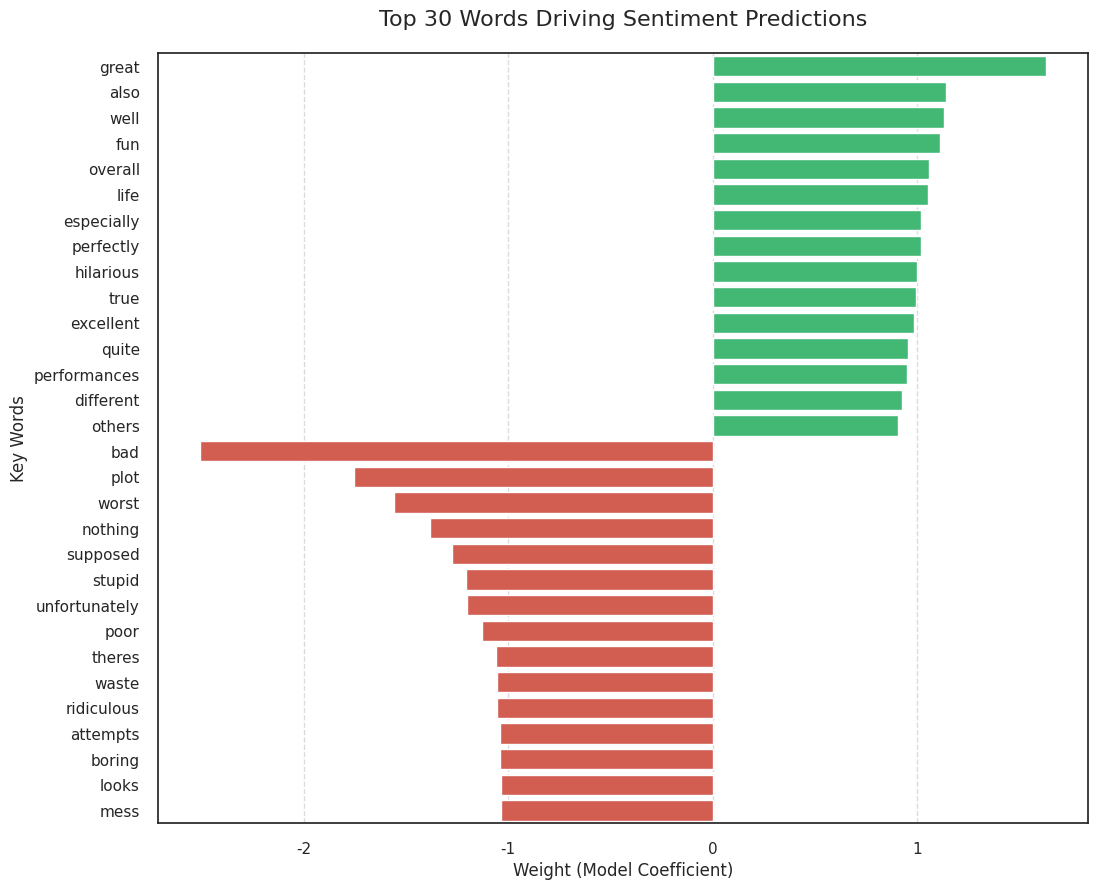

Total features analyzed: 10000


In [ ]:
# --- 1. 提取词汇表和模型权重 ---
# 从 tfidf 步骤获取词汇名称
feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
# tfidf 词汇表 ndarray of shape (n_features,) 如 ['abandoned' 'ability' 'able' ... 'zwick']
# 如果你设置了 max_features=10000，那它的长度就是 10000

# 从 clf 步骤获取模型为这 10000 个词分配的权重系数（Weights）。一维ndarray 如 [ 0.1 -0.2 0.05 ... -0.03]
# 这两个数组是一一对应的。feature_names[0] 的重要性就是 coefficients[0]
coefficients = pipeline.named_steps['clf'].coef_.flatten()

# --- 2. 组合并排序 ---
# 创建 DataFrame 方便操作
importance_df = pd.DataFrame({
    'word': feature_names,
    'weight': coefficients
})

# 分别找出最正向和最负向的 15 个词
top_positive = importance_df.sort_values(by='weight', ascending=False).head(15)
top_negative = importance_df.sort_values(by='weight', ascending=True).head(15)

# 合并在一起画图 上下堆叠
top_features = pd.concat([top_positive, top_negative])

# --- 3. 可视化 ---
plt.figure(figsize=(12, 10))
# 使用条形图，颜色根据权重正负区分
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_features['weight']]
sns.barplot(x='weight', y='word', data=top_features, palette=colors)

plt.title('Top 30 Words Driving Sentiment Predictions', fontsize=16, pad=20)
plt.xlabel('Weight (Model Coefficient)', fontsize=12)
plt.ylabel('Key Words', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

print(f"Total features analyzed: {len(feature_names)}")

TF-IDF 分数：这个词在某篇文档里显不显著（是个性词还是大众词）。

模型权重 (Weight)：它告诉我们这个词和“好坏”的关联度强不强。

举例： "Masterpiece" 可能在某篇影评里 TF-IDF 分数不高（因为它只出现了一次），但它在模型里的 Weight 会非常高。因为模型发现，只要这个词出现，这篇影评 99% 概率是好评